# Labs: My Model - Iteration 1 (Solution)

In this lab project, you will build a trading model based on the popular characteristics for cheap stocks: Low Price-to-Earnings ratio and low Price-to-Book ratio.

For this first iteration, we are going to extract the alphas by simply measuring the distances between the asset's pe and pb from the mean pe and pb, respectively. This operation is called *normalization*.

## 1. Imports and Settings

Copy this code cell into the algorithm:

In [1]:
# Note: Copy to the algorithm

# Module Imports
# --------------------
import quantopian.optimize as opt
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import CustomFactor
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data.morningstar import Fundamentals

from quantopian.pipeline.filters import QTradableStocksUS

import numpy as np
import pandas as pd
from datetime import datetime

# Environment Settings
# --------------------
## Production 
universe = QTradableStocksUS()
mask = {'mask': universe}

## Development
# universe = QTradableStocksUS()
# mask = {'mask': universe}


# Global Configuration
# --------------------


Do not copy this code cell into the algorithm:

In [2]:
from quantopian.research import run_pipeline

# Leave at least 6 months holding period.

## Production 
start_date = datetime.strptime('01/01/2018', '%m/%d/%Y')
end_date = datetime.strptime('06/01/2019', '%m/%d/%Y')

## Development
# start_date = datetime.strptime('03/01/2020', '%m/%d/%Y')
# end_date = datetime.strptime('03/02/2020', '%m/%d/%Y')

## 2. Helpers

The code below can be copied directly into the algorithm.

In [3]:
# Note: Copy to the algorithm

def normalize(data):
    """ Normalize long/short positions
    """
    result = pd.Series(data)
    result = result - np.nanmean(data)
        
    denom = result.abs().sum()
    if denom == 0:
        denom = 1
    
    return result / denom


class Normalize(CustomFactor):
    window_length = 1
    def compute(self, today, assets, out, inp):
        data = normalize(inp[-1, :])
        out[:] = data

In [4]:
def assert_normalize():
    a = normalize(np.array([-300, -200, -100, 0, 100, 200, 300]))
    b = normalize(np.array([-200, -100, 0, 100, 200, 300, 400]))
    c = normalize(np.array([-3, -2, -1, 0, 1, 2, 3]))
    d = normalize(np.array([1,1,1,1,1]))
    assert type(a) == pd.core.series.Series, "Return type must be a pandas.core.series.Series object"
    assert (a == b).all(), "Demean should adjust the mean properly"
    assert (a == c).all(), "Incorrect normalization result"
    assert (d.sum() == 0), "If an array has the same value for all elements, normalized value should be zero for all"
    return True
assert_normalize()

True

## 3. Build Pipeline

The code below can be copied directly into the algorithm.

In [5]:
# Note: Copy to the algorithm

def make_alpha_factors():
    factors = {}
    # Create factors here
    a_pe_ratio = -Fundamentals.pe_ratio.latest.zscore()
    factors['a_pe_ratio'] = a_pe_ratio
    
    a_pb_ratio = -Fundamentals.pb_ratio.latest.zscore()
    factors['a_pb_ratio'] = a_pb_ratio
    
    factor_sum = a_pe_ratio + a_pb_ratio
    factors['a_combined'] = Normalize(inputs=[factor_sum], **mask)
    
    # Not an alpha factor, but useful for later in the grouped tear sheet analysis
    factors['sector'] = Fundamentals.morningstar_sector_code.latest
    return factors
                                        

def make_pipeline():
    alpha_factors = make_alpha_factors()
    factors = {a: alpha_factors[a] for a in alpha_factors}
    pipe = Pipeline(columns=factors, screen=universe)
    
    return pipe

## 4. Run Pipeline

In [6]:
pipe = make_pipeline()
mdf = run_pipeline(pipe, start_date, end_date).dropna(how='all')
mdf.head(5)

a_combined  a_pb_ratio  \
2018-01-02 00:00:00+00:00 Equity(2 [HWM])      0.000312    0.022770   
                          Equity(24 [AAPL])    0.000318    0.021474   
                          Equity(31 [ABAX])    0.000220    0.022205   
                          Equity(41 [ARCB])    0.000237    0.022996   
                          Equity(52 [ABM])     0.000279    0.022903   

                                             a_pe_ratio  sector  
2018-01-02 00:00:00+00:00 Equity(2 [HWM])      0.181708     310  
                          Equity(24 [AAPL])    0.186061     311  
                          Equity(31 [ABAX])    0.128214     206  
                          Equity(41 [ARCB])    0.137129     310  
                          Equity(52 [ABM])     0.161730     310

In [7]:
mdf.index.get_level_values(0)[0]

Timestamp('2018-01-02 00:00:00+0000', tz='UTC', offset='C')

## 5. Analyze Pipeline Result

### 5.1. Validating the normalization process

Checking combined alpha of the first date. Should be close to 1.

In [8]:
first_available_date = mdf.index.get_level_values(0)[0]
selector = mdf.index.get_level_values(0) == first_available_date
mdf.loc[selector]['a_combined'].abs().sum()

1.0000000000000007

### 5.2. Distribution of values

More spread, the better.

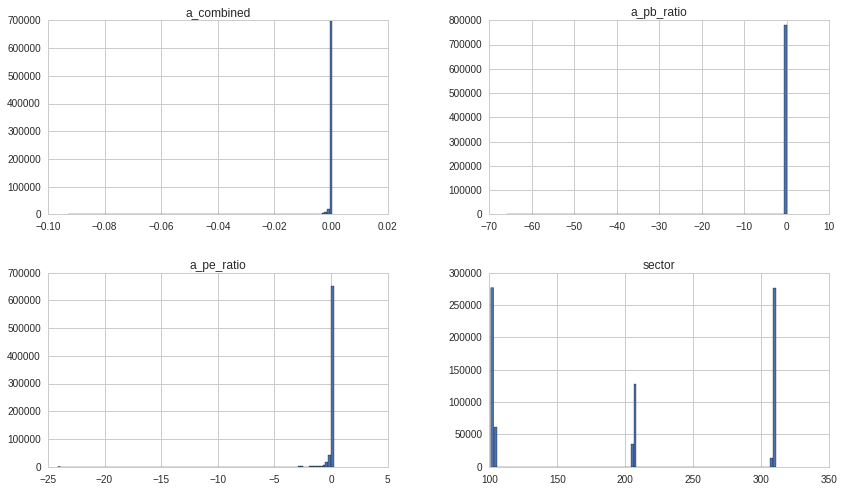

In [9]:
mdf.hist(bins=100);

### 5.3. Correlation between factors

Correlation close to 1.0 (or -1.0) means the factor is probably not needed.

In [10]:
mdf.fillna(0).corr()  # Filling NaNs with 0 assumes empty values are the mean (z-score/rank of 0)
# mdf.corr()  # Drops NaNs; results are not much different

,a_combined,a_pb_ratio,a_pe_ratio,sector
a_combined,1.000000,0.501864,0.847592,-0.037003
a_pb_ratio,0.501864,1.000000,-0.000576,0.009163
a_pe_ratio,0.847592,-0.000576,1.000000,-0.049154
sector,-0.037003,0.009163,-0.049154,1.000000


### 5.4. Number of stocks to trade

1. Total number of stocks considered for trading throughout all dates:

In [11]:
mdf.index.get_level_values(1).unique().shape[0]

2570

2. How many stocks on average do we trade each day?

In [12]:
mdf.dropna(how='all').groupby(level=0).agg('count').mean()[0]

2091.4073033707864

## 6. Get Alpha Factors
 
We have a function below to extract alpha factors from the `factors` DataFrame we have created above. It does two things by default:

1. Replace `np.inf` and `np.nan` to 0, and
2. get the `factors['a_combined']` Series.

Although you may technically combine the alphas in this function, it is preferable to do the alpha combination step on the "Build Pipeline" step above. The reasoning:

The algorithm environment requires this function to accept a $1 \times s$ DataFrame where $s$ is the number of assets, while this research environment requires a $d \times s$ DataFrame where $d$ is the number of dates. Due to this, performing complex operations (such as getting only the extreme values of the combined alpha) may take a very long time on the Notebook environment.

In [13]:
# Note: Adjust as necessary. In here, columns that begins with 'a_' would be
#       considered alpha factors. The rest are for analysis purposes.

filter_col = [col for col in mdf if col.startswith('a_')]
alphas = mdf.loc[:, filter_col]

# Note: Copy to the algorithm

def get_alpha(factors):
    # Replace infs and NaNs
    factors[np.isinf(factors)] = np.nan
    factors.fillna(0, inplace=True)

    combined_alpha = factors['a_combined']
    return combined_alpha

The trading algorithm will use the `combined_alpha` DataFrame.

In [14]:
combined_alpha = get_alpha(alphas)

## 7. Analyze Alphas

### 7.1. Alphas' Statistics

Present some statistics of the alphas here.

In [15]:
alphas.describe()

,a_combined,a_pb_ratio,a_pe_ratio
count,7.907010e+05,790701.000000,790701.000000
mean,-3.950457e-21,0.008197,0.004174
std,1.623683e-03,0.634765,0.859595
min,-9.384826e-02,-66.448111,-24.133846
25%,1.325845e-04,0.021894,0.084256
50%,2.786419e-04,0.026408,0.161684
75%,3.256234e-04,0.034292,0.187171
max,4.187395e-04,0.138045,0.242614


How many % of our signals are shorts?

In [16]:
median_daily_signals = alphas.groupby(level=0).count().median()
percent_short = float(combined_alpha[combined_alpha < 0.0].count()) \
                / float(combined_alpha.count())*100

print("Median number of daily signals: {}".format(median_daily_signals))
print("% of short signals: {}%".format(percent_short))

Median number of daily signals: a_combined    2214.0
a_pb_ratio    2214.0
a_pe_ratio    2214.0
dtype: float64
% of short signals: 12.620067509716062%


### 7.2. Alphalens Analysis

`ANALYZE_ALL` settings:

1. `True`: Analyze all alpha factors in variable `alphas` and the final `combined_alpha` variable.
2. `False`: Analyze only the final factor i.e. the `combined_alpha` variable.

In [17]:
ANALYZE_ALL = True

if ANALYZE_ALL:
    alphas_view = alphas.copy()
else:
    alphas_view = combined_alpha
alphas_view.head(5)

a_combined  a_pb_ratio  \
2018-01-02 00:00:00+00:00 Equity(2 [HWM])      0.000312    0.022770   
                          Equity(24 [AAPL])    0.000318    0.021474   
                          Equity(31 [ABAX])    0.000220    0.022205   
                          Equity(41 [ARCB])    0.000237    0.022996   
                          Equity(52 [ABM])     0.000279    0.022903   

                                             a_pe_ratio  
2018-01-02 00:00:00+00:00 Equity(2 [HWM])      0.181708  
                          Equity(24 [AAPL])    0.186061  
                          Equity(31 [ABAX])    0.128214  
                          Equity(41 [ARCB])    0.137129  
                          Equity(52 [ABM])     0.161730

In [18]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

# 1 day, 1 week, 1 month, 1 quarter
periods = [1, 5, 22, 64]

# Get pricing data (extends 6 months to minimize dropping in Alphalens)
new_start_date = start_date - relativedelta(months=6)
new_end_date = end_date + relativedelta(months=6)
assets = alphas_view.reset_index()['level_1'].unique()
dates = alphas_view.reset_index()['level_0'].unique()
prices = get_pricing(assets, start_date=new_start_date, end_date=new_end_date, fields='close_price')
prices.head(5)

,Equity(2 [HWM]),Equity(24 [AAPL]),Equity(31 [ABAX]),Equity(41 [ARCB]),Equity(52 [ABM]),Equity(53 [ABMD]),Equity(62 [ABT]),Equity(64 [GOLD]),Equity(67 [ADSK]),Equity(76 [TAP]),...,Equity(40848 [FLDM]),Equity(7259 [SXI]),Equity(16743 [DX]),Equity(51995 [TALO]),Equity(50695 [PSDO]),Equity(52361 [BPYU]),Equity(52362 [KLXE]),Equity(4886 [MITK]),Equity(49607 [AXSM]),Equity(38296 [RST])
2017-07-03 00:00:00+00:00,22.350,138.253,52.992,20.851,39.769,142.38,46.557,15.191,99.340,80.451,...,4.115,89.422,15.930,NaN,14.141,NaN,NaN,8.25,5.30,10.69
2017-07-05 00:00:00+00:00,22.506,138.812,52.754,20.509,39.358,142.31,46.834,15.522,102.610,80.572,...,3.770,88.396,15.976,NaN,14.496,NaN,NaN,8.20,5.15,10.49
2017-07-06 00:00:00+00:00,22.438,137.492,51.755,20.314,38.785,140.02,45.849,15.240,102.060,80.292,...,3.800,88.836,15.771,NaN,13.983,NaN,NaN,8.25,5.30,10.39
2017-07-07 00:00:00+00:00,22.624,138.889,52.052,21.046,39.320,142.12,46.299,14.963,103.320,80.237,...,3.900,89.960,15.680,NaN,14.447,NaN,NaN,8.50,5.50,10.72
2017-07-10 00:00:00+00:00,23.318,139.775,51.641,21.388,38.900,141.21,46.117,15.376,103.745,79.761,...,3.960,89.471,15.520,NaN,14.289,NaN,NaN,9.45,5.45,10.48


In [19]:
import alphalens as al
from scipy import stats

def get_table(ic_data, ab_data):
    summary_table = pd.DataFrame()
    summary_table["Ann. Alpha"] = ab_data.loc['Ann. alpha']
    summary_table["beta"] = ab_data.loc['beta']
    summary_table["IC Mean"] = ic_data.mean()
    summary_table["IC Std."] = ic_data.std()
    summary_table["Risk-Adjusted IC"] = \
        ic_data.mean() / ic_data.std()
    t_stat, p_value = stats.ttest_1samp(ic_data, 0)
    summary_table["p-value(IC)"] = p_value

    return summary_table.apply(lambda x: x.round(3)).T


results = None
for i, col in enumerate(sorted(alphas_view.columns)):
    if i > 0:
        print('')
    print(col)
    
    # Get the factor data
    data = alphas_view[col]
    data = data[data != 0].dropna()
    try:
        factor_data = al.utils.get_clean_factor_and_forward_returns(data,
                                                                    prices,
                                                                    quantiles=5,
                                                                    periods=periods,
                                                                    max_loss=1.
                                                                   )

        # Output the results
        ic = al.performance.factor_information_coefficient(factor_data)
        ic.columns = pd.MultiIndex.from_product([[col], ic.columns])

        returns = al.performance.factor_returns(factor_data)
        ab = al.performance.factor_alpha_beta(factor_data, returns=returns)
        ab.columns = pd.MultiIndex.from_product([[col], ab.columns])

        table = get_table(ic, ab)

        if results is None:
            results = table
        else:
            results = pd.concat([results, table], axis=1)
            
    except Exception as e:
        print('Error: {}'.format(e))
        continue
        
temp = None
i = 0
unique_vals = results.columns.get_level_values(0).unique()
for j, factor in enumerate(sorted(unique_vals)):
    i += 1
    res = results.xs(factor, axis=1, level=0, drop_level=False)
    
    if temp is None:
        temp = res
    else:
        temp = pd.concat([temp, res], axis=1)
        
    if i > 4 or j == len(unique_vals) - 1:
        display(temp)
        temp = None
        i = 0

a_combined
Dropped 1.3% entries from factor data: 1.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!

a_pb_ratio
Dropped 1.3% entries from factor data: 1.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!

a_pe_ratio
Dropped 1.3% entries from factor data: 1.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!


a_combined                      a_pb_ratio                \
                         1D     5D    22D    64D         1D     5D    22D   
Ann. Alpha           -0.031 -0.036 -0.045 -0.041      0.078  0.050  0.025   
beta                 -0.050 -0.059 -0.053 -0.075     -0.079 -0.177 -0.228   
IC Mean              -0.013 -0.025 -0.050 -0.083     -0.021 -0.035 -0.057   
IC Std.               0.103  0.099  0.087  0.063      0.138  0.132  0.114   
Risk-Adjusted IC     -0.128 -0.252 -0.570 -1.328     -0.150 -0.262 -0.501   
p-value(IC)           0.016  0.000  0.000  0.000      0.005  0.000  0.000   

                        a_pe_ratio                       
                    64D         1D     5D    22D    64D  
Ann. Alpha        0.075     -0.063 -0.064 -0.068 -0.073  
beta             -0.161     -0.042 -0.027 -0.006 -0.062  
IC Mean          -0.084     -0.012 -0.023 -0.047 -0.081  
IC Std.           0.077      0.099  0.097  0.082  0.059  
Risk-Adjusted IC -1.079     -0.123 -0.240 -0.569 -1.367  
p-value(IC)       0.000      0.021  0.000  0.000  0.000

## 8. Tear Sheet Analysis

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import empyrical as ep
import alphalens as al
import pyfolio as pf

from quantopian.research.experimental import get_factor_returns, get_factor_loadings

# Load risk factor loadings and returns
factor_loadings = get_factor_loadings(assets, start_date, new_end_date)
factor_returns = get_factor_returns(start_date, new_end_date)

# Fix a bug in the risk returns
factor_returns.loc[factor_returns.value.idxmax(), 'value'] = 0

def calc_perf_attrib(portfolio_returns, portfolio_pos, factor_returns, factor_loadings):
    start = portfolio_returns.index[0]
    end = portfolio_returns.index[-1]
    factor_loadings.index = factor_loadings.index.set_names(['dt', 'ticker'])
    portfolio_pos.index = portfolio_pos.index.set_names(['dt'])
    
    portfolio_pos = portfolio_pos.drop('cash', axis=1)
    portfolio_pos.columns.name = 'ticker'
    portfolio_pos.columns = portfolio_pos.columns.astype('int')
    
    return ep.perf_attrib(
        portfolio_returns, 
        portfolio_pos.stack().dropna(),
        factor_returns.loc[start:end], 
        factor_loadings.loc[start:end])

def plot_exposures(risk_exposures, ax=None):
    rep = risk_exposures.stack().reset_index()
    rep.columns = ['dt', 'factor', 'exposure']
    sns.boxplot(x='exposure', y='factor', data=rep, orient='h', ax=ax, order=risk_exposures.columns[::-1])

def compute_turnover(df):
    return df.dropna().unstack().dropna(how='all').fillna(0).diff().abs().sum(1)

def get_max_median_position_concentration(expos):
    longs = expos.loc[expos > 0]
    shorts = expos.loc[expos < 0]

    return expos.groupby(level=0).quantile([.05, .25, .5, .75, .95]).unstack()

def compute_factor_stats(factor, pricing, factor_returns, factor_loadings, periods=range(1, 15), view=None):
    factor_data_total = al.utils.get_clean_factor_and_forward_returns(
        factor, 
        pricing,
        quantiles=None,
        bins=(-np.inf, 0, np.inf),
        periods=periods,
        cumulative_returns=False,
    )

    portfolio_returns_total = al.performance.factor_returns(factor_data_total)
    portfolio_returns_total.columns = portfolio_returns_total.columns.map(lambda x: int(x[:-1]))
    for i in portfolio_returns_total.columns:
        portfolio_returns_total[i] = portfolio_returns_total[i].shift(i)

    portfolio_returns_specific = pd.DataFrame(columns=portfolio_returns_total.columns, index=portfolio_returns_total.index)
    
    # closure
    def calc_perf_attrib_c(i, portfolio_returns_total=portfolio_returns_total, 
                           factor_data_total=factor_data_total, factor_returns=factor_returns, 
                           factor_loadings=factor_loadings):
        return calc_perf_attrib(portfolio_returns_total[i], 
                                factor_data_total['factor'].unstack().assign(cash=0).shift(i), 
                                factor_returns, factor_loadings)
    
    if view is None:
        perf_attrib = map(calc_perf_attrib_c, portfolio_returns_total.columns)
    else:
        perf_attrib = view.map_sync(calc_perf_attrib_c, portfolio_returns_total.columns)
        
    for i, pa in enumerate(perf_attrib):
        if i == 0:
            risk_exposures_portfolio = pa[0]
            perf_attribution = pa[1]
        portfolio_returns_specific[i + 1] = pa[1]['specific_returns']
    
    delay_sharpes_total = portfolio_returns_total.apply(ep.sharpe_ratio)
    delay_sharpes_specific = portfolio_returns_specific.apply(ep.sharpe_ratio)
    
    turnover = compute_turnover(factor)
    n_holdings = factor.groupby(level=0).count()
    perc_holdings = get_max_median_position_concentration(factor)
    
    return {'factor_data_total': factor_data_total, 
            'portfolio_returns_total': portfolio_returns_total,
            'portfolio_returns_specific': portfolio_returns_specific,
            'risk_exposures_portfolio': risk_exposures_portfolio,
            'perf_attribution': perf_attribution,
            'delay_sharpes_total': delay_sharpes_total,
            'delay_sharpes_specific': delay_sharpes_specific,
            'turnover': turnover,
            'n_holdings': n_holdings,
            'perc_holdings': perc_holdings,
    }

def plot_overview_tear_sheet(factor, pricing, factor_returns, factor_loadings, periods=range(1, 15), view=None):
    fig = plt.figure(figsize=(16, 16))
    gs = plt.GridSpec(5, 4)
    ax1 = plt.subplot(gs[0:2, 0:2])
    
    factor_stats = compute_factor_stats(factor, pricing, factor_returns, factor_loadings, periods=periods, view=view)
                         
    sharpes = pd.DataFrame({'specific': factor_stats['delay_sharpes_specific'], 
                  'total': factor_stats['delay_sharpes_total']})
#     display(sharpes)
    sharpes.plot.bar(ax=ax1)
    ax1.set(xlabel='delay', ylabel='IR')

    ax2a = plt.subplot(gs[0, 2:4])
    delay_cum_rets_total = factor_stats['portfolio_returns_total'][list(range(1, 5))].apply(ep.cum_returns)
    delay_cum_rets_total.plot(ax=ax2a)
    ax2a.set(title='Total returns', ylabel='Cumulative returns')
    
    ax2b = plt.subplot(gs[1, 2:4])
    delay_cum_rets_specific = factor_stats['portfolio_returns_specific'][list(range(1, 5))].apply(ep.cum_returns)
    delay_cum_rets_specific.plot(ax=ax2b)
    ax2b.set(title='Specific returns', ylabel='Cumulative returns')
    
    ax3 = plt.subplot(gs[2:4, 0:2])
    plot_exposures(factor_stats['risk_exposures_portfolio'].reindex(columns=factor_stats['perf_attribution'].columns), 
                   ax=ax3)

    ax4 = plt.subplot(gs[2:4, 2])
    ep.cum_returns_final(factor_stats['perf_attribution']).plot.barh(ax=ax4)
    ax4.set(xlabel='Cumulative returns')

    ax5 = plt.subplot(gs[2:4, 3], sharey=ax4)
    factor_stats['perf_attribution'].apply(ep.annual_volatility).plot.barh(ax=ax5)
    ax5.set(xlabel='Ann. volatility')

    ax6 = plt.subplot(gs[-1, 0:2])
    factor_stats['n_holdings'].plot(color='b', ax=ax6)
    ax6.set_ylabel('# holdings', color='b')
    ax6.tick_params(axis='y', labelcolor='b')
    
    ax62 = ax6.twinx()
    factor_stats['turnover'].plot(color='r', ax=ax62)
    ax62.set_ylabel('turnover', color='r')
    ax62.tick_params(axis='y', labelcolor='r')
    
    ax7 = plt.subplot(gs[-1, 2:4])
    factor_stats['perc_holdings'].plot(ax=ax7)
    ax7.set_ylabel('Perc. holdings')

    
    gs.tight_layout(fig)
    
    return fig, factor_stats, sharpes

/venvs/py35/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/venvs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


a_combined
Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


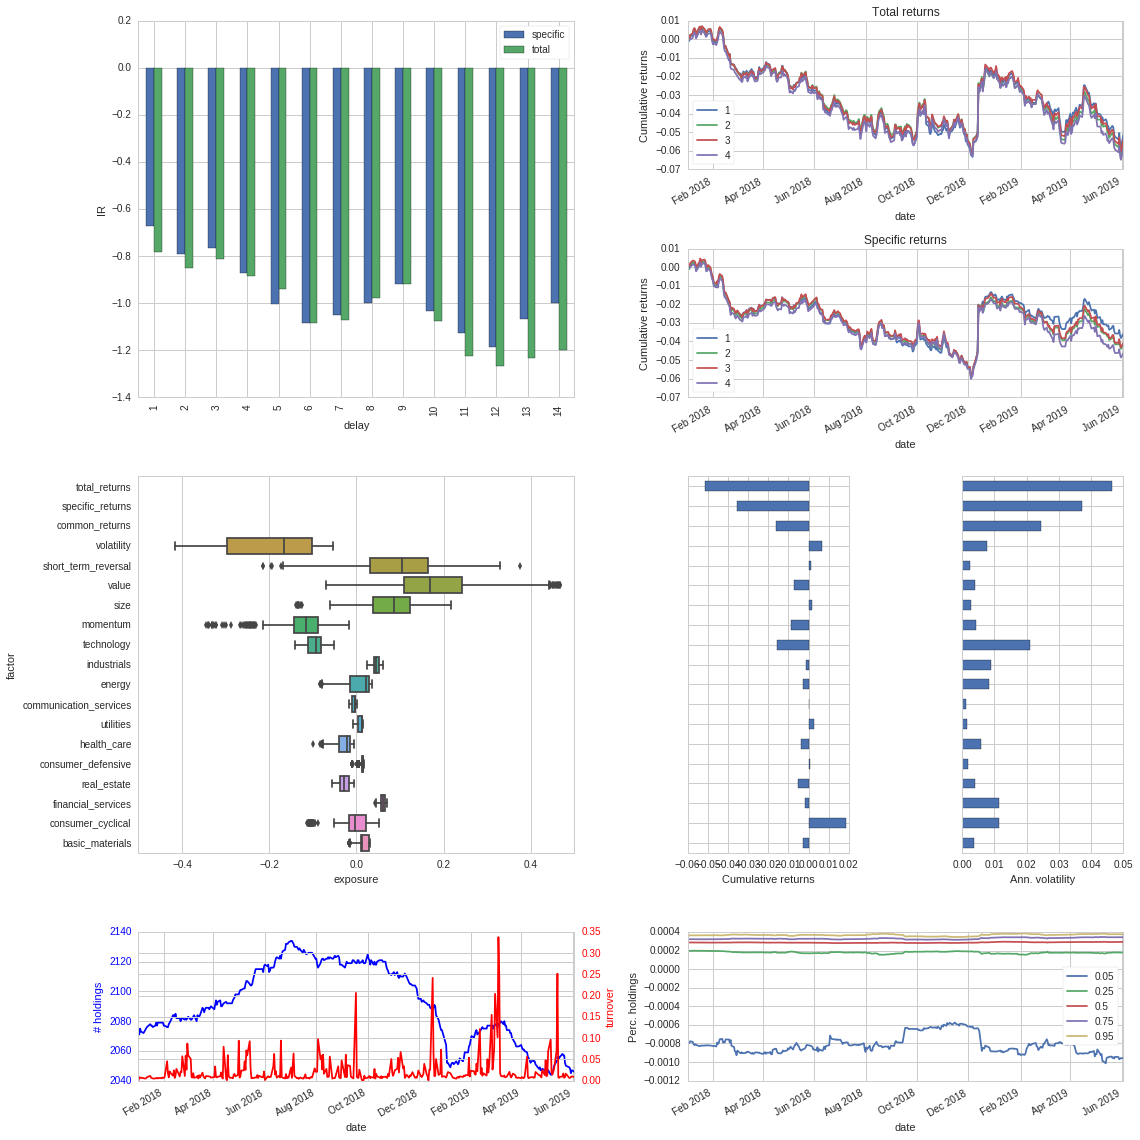


a_pb_ratio
Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


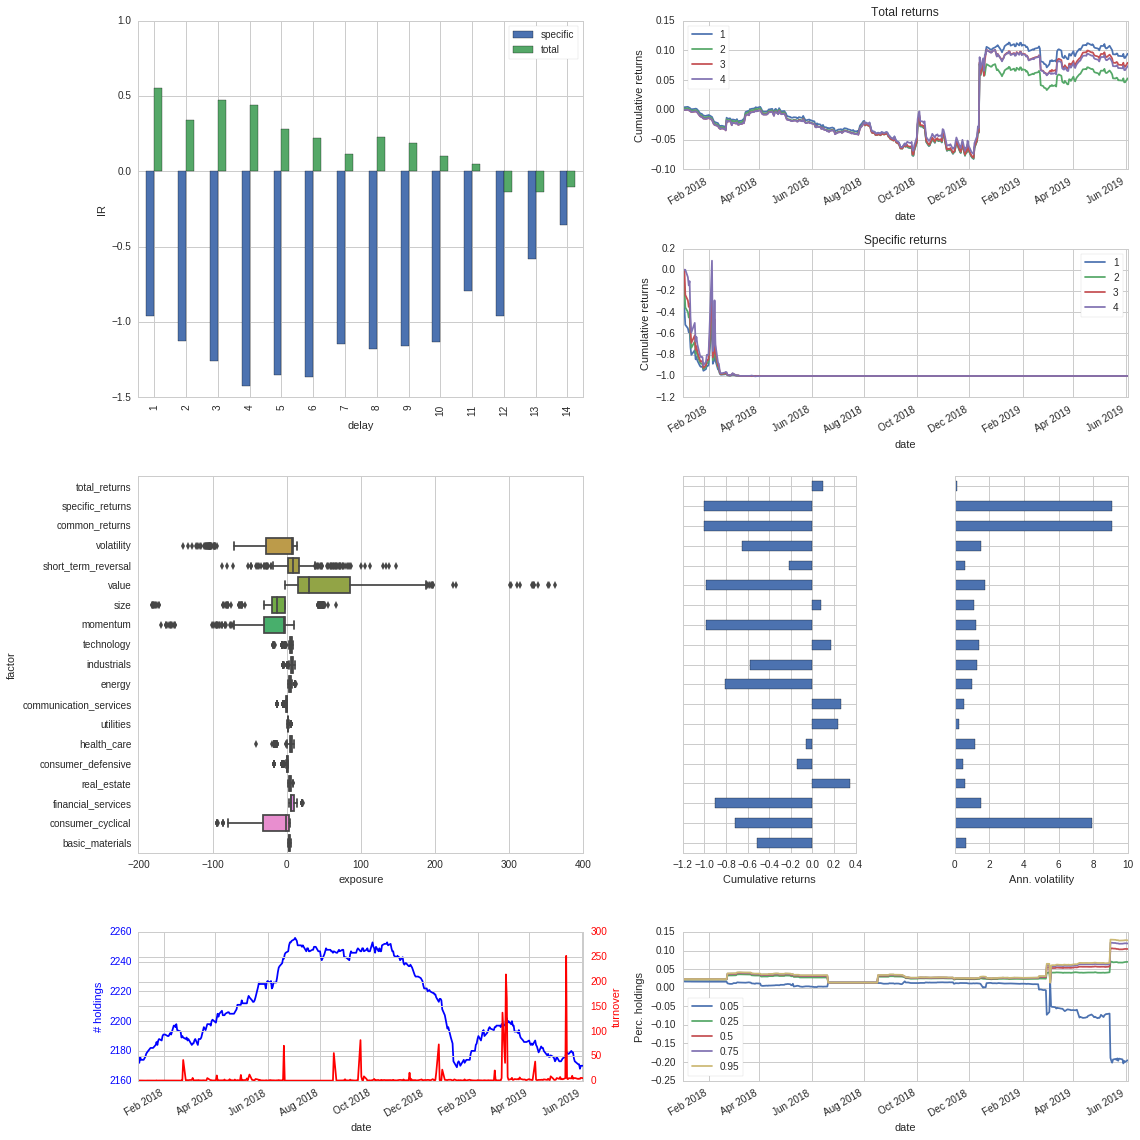


a_pe_ratio
Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


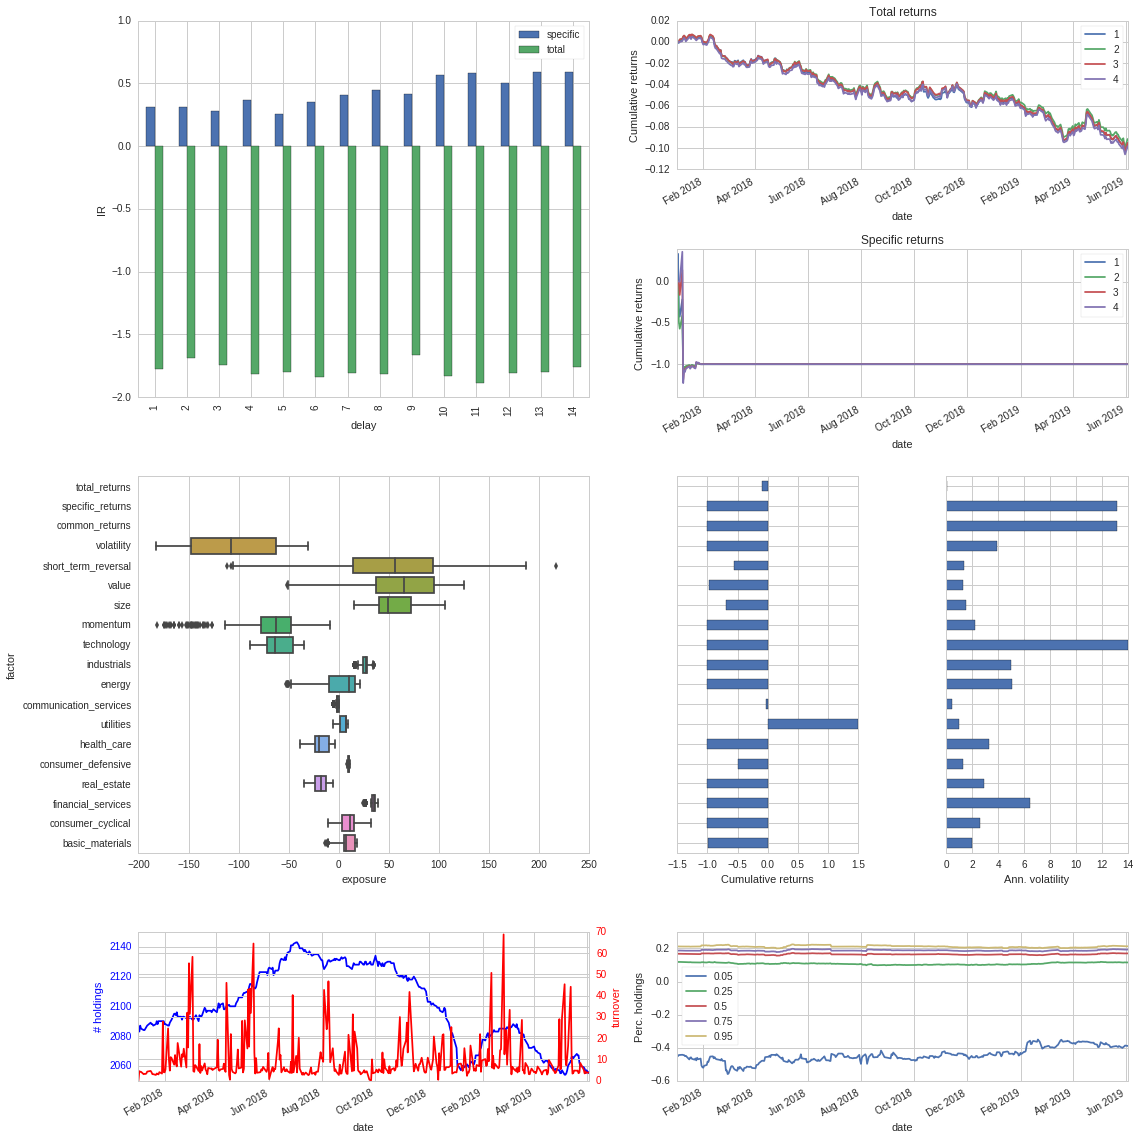

In [21]:
# Loop through all columns
results = None
for i, col in enumerate(sorted(alphas_view.columns)):
    if i > 0:
        print('')
    print(col)
    
    # Get the factor data
    try:
        data = alphas_view[col]
        data = data[data != 0].dropna()
        fig, factor_stats, sharpes = plot_overview_tear_sheet(data,
                                                     prices,
                                                     factor_returns,
                                                     factor_loadings);
        plt.show()
        
        sharpes.columns = pd.MultiIndex.from_product([[col], sharpes.columns])
        if results is None:
            results = sharpes
        else:
            results = pd.concat([results, sharpes], axis=1)
        
    except Exception as e:
        print('Error: {}'.format(e))
        continue
        
# results

In [22]:
MORNINGSTAR_SECTOR_CODES = {
     -1: 'Misc',
    101: 'Basic Materials',
    102: 'Consumer Cyclical',
    103: 'Financial Services',
    104: 'Real Estate',
    205: 'Consumer Defensive',
    206: 'Healthcare',
    207: 'Utilities',
    308: 'Communication Services',
    309: 'Energy',
    310: 'Industrials',
    311: 'Technology' ,    
}

sectors = mdf['sector']

factor_data = al.utils.get_clean_factor_and_forward_returns(factor=combined_alpha,
                                                            prices=prices,
                                                            groupby=sectors,
                                                            groupby_labels=MORNINGSTAR_SECTOR_CODES,
                                                            periods=periods, max_loss=10000)

Dropped 1.3% entries from factor data: 1.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 1000000.0%, not exceeded: OK!
